In [1]:
import numpy as np
import matplotlib.pyplot as plt

from openseize import producer
from openseize.io.edf import Reader
from openseize.demos import paths
from openseize.filtering.fir import Kaiser

In [2]:
#read in a few secs of data
fp = paths.locate('recording_001.edf')
reader = Reader(fp)
reader.channels = [0]
data = reader.read(0, 20000)

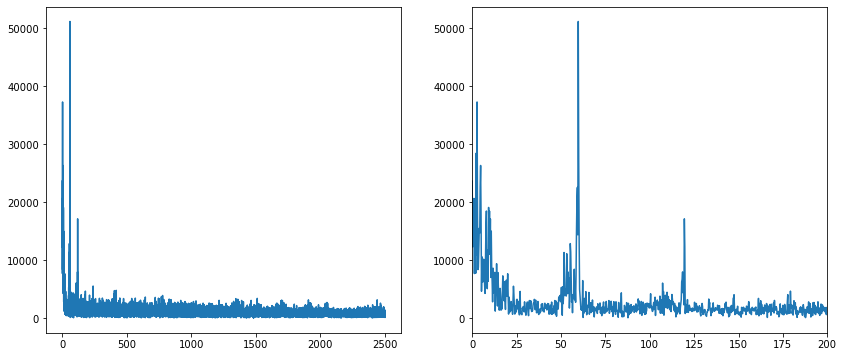

In [34]:
xf = np.fft.rfft(data)[0]
xfreqs = np.fft.rfftfreq(len(data[0]), d=1/5000)

fig, axarr = plt.subplots(1,2, figsize=(14, 6))
axarr[0].plot(xfreqs, np.abs(xf))
axarr[1].plot(xfreqs, np.abs(xf))
axarr[1].set_xlim([0,200])
plt.show()

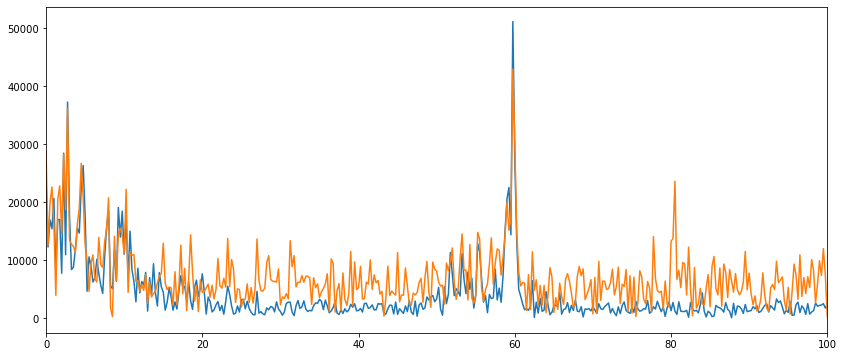

'\ny = data[0, ::25]\nyf = np.fft.fft(y)\nyf = np.fft.fftshift(yf)\n\nyfreqs = np.fft.fftshift(np.fft.fftfreq(len(yf), d=1/200))\nplt.plot(yfreqs, 25*np.abs(yf))\nplt.show()\n'

In [35]:
y = data[0, ::25]
yf = np.fft.rfft(y)
yfreqs = np.fft.rfftfreq(len(y), d=1/200)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(xfreqs, np.abs(xf))
ax.plot(yfreqs, 25*np.abs(yf))
ax.set_xlim([0,100])
plt.show()

"""
y = data[0, ::25]
yf = np.fft.fft(y)
yf = np.fft.fftshift(yf)

yfreqs = np.fft.fftshift(np.fft.fftfreq(len(yf), d=1/200))
plt.plot(yfreqs, 25*np.abs(yf))
plt.show()
"""

Next show that by first low-pass filtering the data we get the expected FFT after downsampling

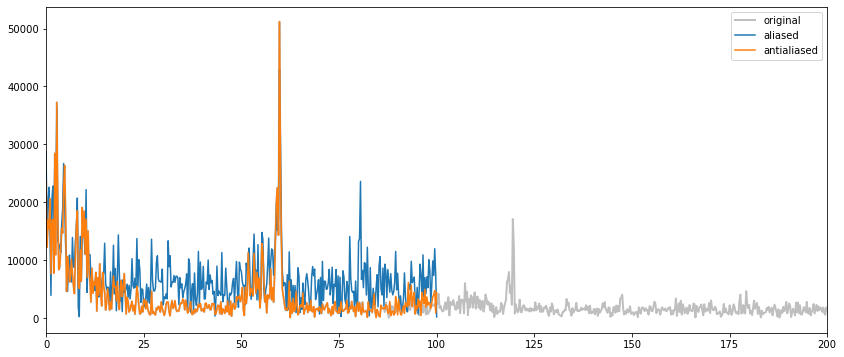

In [45]:
kaiser = Kaiser(fpass=100, fstop=120, gpass=0.05, gstop=40, fs=5000)
filtered = kaiser(data, chunksize=10e6, axis=-1)

z = filtered[0, ::25]

zf = np.fft.rfft(z)
zfreqs = np.fft.rfftfreq(len(z), d=1/200)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(xfreqs, np.abs(xf), label='original', linewidth=2, color='gray', alpha=0.5)
ax.plot(yfreqs, 25*np.abs(yf), label='aliased')
ax.plot(zfreqs, 25*np.abs(zf), label='antialiased')
ax.set_xlim([0,200])
ax.legend()
plt.show()


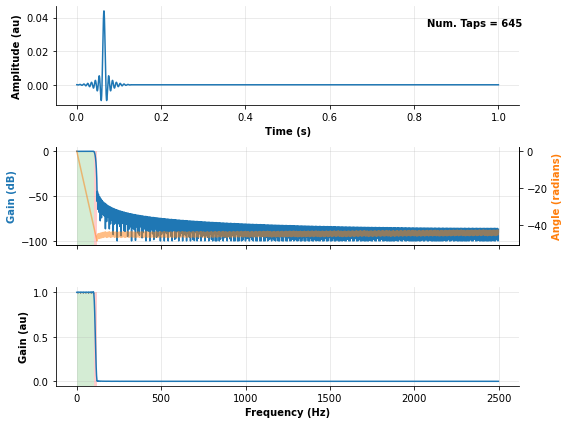

In [43]:
kaiser.plot()